## Multiple Breakpoints

Notebook to make different subplots for the figure illustrating the basic clipped relu

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
current_directory = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_directory, os.pardir)))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mayavi import mlab
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline
from lrr_annot.loader import Loader
from lrr_annot.analyzer import compute_winding, compute_regression, median_slope, compute_lrr_std
from lrr_annot.plotter import plot_regression, plot_residue_annotations_3d

### Load in sequence and alphafold confidences 

In [2]:
from Bio.PDB import PDBParser
protid = "AT1G72840.2"

loader = Loader()
loader.load_single("../data/a_thaliana_alpha", f"{protid}.pdb")
X = loader.structures[protid]
bfactor = loader.bfactors[protid]

### Compute winding number

In [3]:
winding_res = compute_winding(X)
winding = winding_res["winding"]

## Compute 2 breakpoints, and use this as an initial guess to compute 4 breakpoints

In [4]:
regression_res_2 = compute_regression(winding, n_breakpoints=2)

[a, b] = regression_res_2['breakpoints']
breakpoints = [a, a + (b-a)/2, a + (b-a)/2 + 1, b]
regression_res_4 = compute_regression(winding, n_breakpoints=4, initial_guess=breakpoints)

/home/ctralie/miniconda3/envs/py311/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ctralie/miniconda3/envs/py311/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Compare winding number to bandpass b-factor

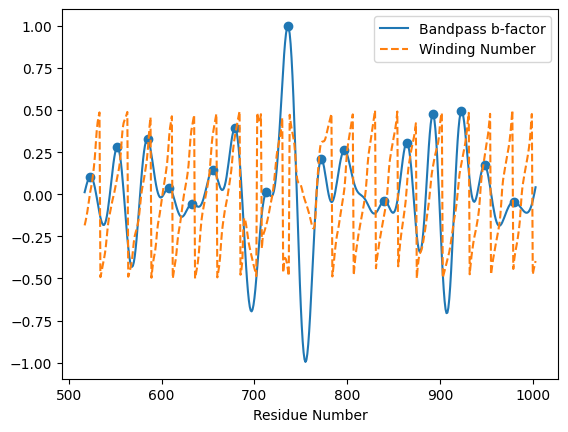

In [5]:
from scipy import signal
[a, b] = regression_res_2['breakpoints']
rg = np.arange(a, b)

period = 25

sos = signal.butter(10, [0.5/period, 2/period], 'bandpass', output='sos')
bff = signal.sosfiltfilt(sos, bfactor)
bff = bff[a:b]
bff /= np.max(bff)
idx = np.arange(1, bff.size-1)
idx = idx[(bff[idx] > bff[idx-1])*(bff[idx] > bff[idx+1])]

plt.plot(rg, bff)
plt.plot(rg, winding[rg]%1 - 0.5, linestyle='--')
plt.scatter(rg[idx], bff[idx])
plt.xlabel("Residue Number")
plt.legend(["Bandpass b-factor", "Winding Number"])

## Plots showing what happens when we use 2 breakpoint regression

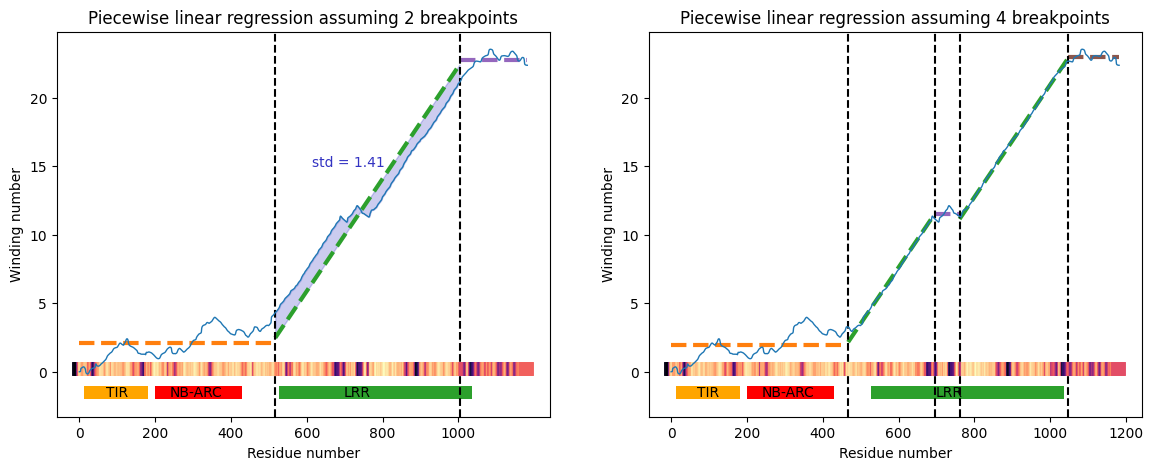

In [6]:
from scipy import signal

## Step 0: Define the domains
def draw_domains(N):
    domains = [(13, 182), (200, 429), (528, 1037)]
    colors = ['orange', 'red', 'C2']
    texts = ["TIR", "NB-ARC", "LRR"]
    rectheight = 1
    for domain, color, text in zip(domains, colors, texts):
        start, end = domain
        rect = patches.Rectangle((start, -rectheight*2), end - start, rectheight, facecolor=color)
        plt.gca().add_patch(rect)
        plt.text(start+(end-start)/len(text), -rectheight*1.8, text)
    plt.plot([0, N], [0]*2, color='k', linewidth=1)

plt.figure(figsize=(14, 5))
## Step 1: Plot 2 breakpoint results with deviation fill between
plt.subplot(121)
breakpoints = regression_res_2["breakpoints"]
slope = regression_res_2["slope"]
plot_regression(plt.gca(), winding, breakpoints, slope, colors=["C1", "C2", "C4"])
N = winding.size
draw_domains(N)

#sos = signal.butter(10, 0.05, 'lowpass', output='sos')
#bfn = signal.sosfiltfilt(sos, bfactor)
bfn = bfactor - np.min(bfactor)
bfn /= np.max(bfn)
C = plt.cm.magma(bfn)
for i in range(N-1):
    plt.plot([i, i+1], [0.2, 0.2], c=C[i], linewidth=10)
xticks = list(range(0, 1001, 200))
plt.xticks(xticks);
plt.yticks([0, 5, 10, 15, 20]);

[a, b] = breakpoints[0:2]
linear = slope * (np.arange(a, b) - (a + b - 1) / 2)
y = linear + np.mean(winding[a:b])
rg = np.arange(a, b)
#plt.plot(rg, winding[a:b]-y)
plt.fill_between(rg, y, winding[a:b], color=np.array([0, 0, 0.7, 0.2]))
std = compute_lrr_std(winding, breakpoints, slope)
plt.text(a + (b-a)/5, 15, "std = {:.2f}".format(std), c=np.array([0, 0, 0.7, 0.8]))
plt.title("Piecewise linear regression assuming 2 breakpoints")

## Step 3: Plot 4 breakpoint results
plt.subplot(122)
breakpoints = regression_res_4["breakpoints"]
slope = regression_res_4["slope"]
plot_regression(plt.gca(), winding, breakpoints, slope, colors=["C1", "C2", "C4", "C2", "C5"])
draw_domains(N)
for i in range(N-1):
    plt.plot([i, i+1], [0.2, 0.2], c=C[i], linewidth=10)
plt.title("Piecewise linear regression assuming 4 breakpoints")


plt.savefig("Multibreakpoint_Plots.svg", bbox_inches='tight')

## Make Plot of Annotated Regions in 3D

In [7]:
from mayavi import mlab

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = [int(c[1:], 16) for c in colors]
colors = [((c//65536), ((c%65536)//256), (c%256)) for c in colors]

X = loader.structures[protid]
plot_residue_annotations_3d(X, breakpoints, [colors[1], colors[2], colors[4], colors[2], colors[5]])
mlab.show()